Importing libraries

In [671]:
import pandas  as pd #Data manipulation
import numpy as np #Data manipulation
import matplotlib.pyplot as plt # Visualization
import seaborn as sns #Visualization
import random as rd
from random import seed
from random import randrange
from random import random
from csv import reader
from math import exp
plt.rcParams['figure.figsize'] = [8,5]
plt.rcParams['font.size'] =14
plt.rcParams['font.weight']= 'bold'
plt.style.use('seaborn-whitegrid')

#Backpropagation on the Seeds Dataset 

## From scratch

Load a CSV file

In [672]:
def load_csv(filename):
	dataset = []
	with open(filename, 'r') as file:
		csv_reader = reader(file)
		for row in csv_reader:
			if not row:
				continue
			dataset.append(row)
	return dataset

Convert string column to integer

In [673]:
def str_column_to_int(dataset, column):
	class_values = [row[column] for row in dataset]
	unique = set(class_values)
	lookup = {}
	for i, value in enumerate(unique):
		lookup[value] = i
	for row in dataset:
		row[column] = lookup[row[column]]
	return lookup

Convert string column to float

In [674]:
def str_column_to_float(dataset, column):
	for row in dataset:
		row[column] = float(row[column].strip())


Find the minimum and maximum values for each column


In [675]:
def dataset_minmax(dataset):
	stats = [[min(column), max(column)] for column in zip(*dataset)]
	return stats

Split a dataset into k folds

In [677]:
def cross_validation_split(dataset, n_folds):
	dataset_split = []
	dataset_copy = list(dataset)
	fold_size = int(len(dataset) / n_folds)
	for i in range(n_folds):
		fold = []
		while len(fold) < fold_size:
			index = randrange(len(dataset_copy))
			fold.append(dataset_copy.pop(index))
		dataset_split.append(fold)
	return dataset_split

Rescale dataset columns to the range 0-1

In [676]:
def normalize_dataset(dataset, minmax):
	for row in dataset:
		for i in range(len(row)-1):
			row[i] = (row[i] - minmax[i][0]) / (minmax[i][1] - minmax[i][0])

Calculate accuracy percentage

In [678]:
def accuracy_metric(actual, predicted):
	correct = 0
	for i in range(len(actual)):
		if actual[i] == predicted[i]:
			correct += 1
	return correct / float(len(actual)) * 100.0

Evaluate an algorithm using a cross validation split

In [679]:
def evaluate_algorithm(dataset, algorithm, n_folds, *args):
	folds = cross_validation_split(dataset, n_folds)
	scores = []
	for fold in folds:
		train_set = list(folds)
		train_set.remove(fold)
		train_set = sum(train_set, [])
		test_set = []
		for row in fold:
			row_copy = list(row)
			test_set.append(row_copy)
			row_copy[-1] = None
		predicted = algorithm(train_set, test_set, *args)
		actual = [row[-1] for row in fold]
		accuracy = accuracy_metric(actual, predicted)
		scores.append(accuracy)
	return scores

Calculate neuron activation for an input

In [680]:
def activate(weights, inputs):
	activation = weights[-1]
	for i in range(len(weights)-1):
		activation += weights[i] * inputs[i]
	return activation

Transfer neuron activation

In [681]:
def transfer(activation):
	return 1.0 / (1.0 + exp(-activation))

Forward propagate input to a network output

In [682]:
def forward_propagate(network, row):
	inputs = row
	for layer in network:
		new_inputs = []
		for n in layer:
			activation = activate(n['weights'], inputs)
			n['output'] = transfer(activation)
			new_inputs.append(n['output'])
		inputs = new_inputs
	return inputs

Calculate the derivative of an neuron output

In [683]:
def transfer_derivative(output):
	return output * (1.0 - output)

Backpropagate error and store in neurons

In [684]:
def backward_propagate_error(network, expected):
	for i in reversed(range(len(network))):
		layer = network[i]
		errors = []
		if i != len(network)-1:
			for j in range(len(layer)):
				error = 0.0
				for n in network[i + 1]:
					error += (n['weights'][j] * n['delta'])
				errors.append(error)
		else:
			for j in range(len(layer)):
				n = layer[j]
				errors.append(expected[j] - n['output'])
		for j in range(len(layer)):
			n = layer[j]
			n['delta'] = errors[j] * transfer_derivative(n['output'])

Update network weights with error

In [685]:
def update_weights(network, row, l_rate):
	for i in range(len(network)):
		inputs = row[:-1]
		if i != 0:
			inputs = [n['output'] for n in network[i - 1]]
		for n in network[i]:
			for j in range(len(inputs)):
				n['weights'][j] += l_rate * n['delta'] * inputs[j]
			n['weights'][-1] += l_rate * n['delta']

Train a network for a fixed number of epochs

In [686]:
def train_network(network, train, l_rate, n_epoch, n_outputs):
	for epoch in range(n_epoch):
		for row in train:
			outputs = forward_propagate(network, row)
			expected = [0 for i in range(n_outputs)]
			expected[row[-1]] = 1
			backward_propagate_error(network, expected)
			update_weights(network, row, l_rate)

Initialize a network

In [687]:
def initialize_network(n_inputs, n_hidden, n_outputs):
	network = []
	hidden_lay = [{'weights':[random() for i in range(n_inputs + 1)]} for i in range(n_hidden)]
	network.append(hidden_lay)
	output_lay = [{'weights':[random() for i in range(n_hidden + 1)]} for i in range(n_outputs)]
	network.append(output_lay)
	return network 

Make a prediction with a network

In [688]:
def predict(network, row):
	outputs = forward_propagate(network, row)
	return outputs.index(max(outputs))

Backpropagation Algorithm With Stochastic Gradient Descent

In [689]:
def back_propagation(train, test, l_rate, n_epoch, n_hidden):
	n_inputs = len(train[0]) - 1
	n_outputs = len(set([row[-1] for row in train]))
	network = initialize_network(n_inputs, n_hidden, n_outputs)
	train_network(network, train, l_rate, n_epoch, n_outputs)
	predictions = []
	for row in test:
		prediction = predict(network, row)
		predictions.append(prediction)
	return (predictions)

Test Backprop on Seeds dataset

In [690]:
seed(1)

Load and prepare data

In [691]:
filename = 'seeds_dataset.csv'
df = pd.read_csv(filename)
dataset = load_csv(filename)
for i in range(len(dataset[0])-1):
	str_column_to_float(dataset, i)

Exploratory Data Analysis

In [692]:
df.isnull().sum()

15.26    0
14.84    0
0.871    0
5.763    0
3.312    0
2.221    0
5.22     0
1        0
dtype: int64

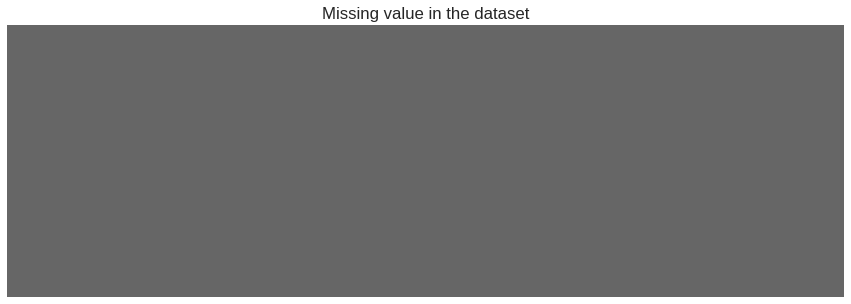

In [693]:
plt.figure(figsize=(15,5))
sns.heatmap(df.isnull(),cbar=False,cmap='Dark2_r',yticklabels=False, xticklabels=False)
plt.title('Missing value in the dataset');

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Distribution of the 3 output classes')

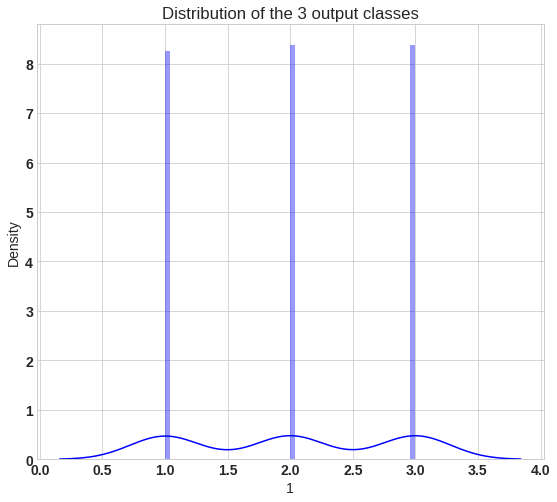

In [694]:
f= plt.figure(figsize=(20,8))

ax=f.add_subplot(121)
sns.distplot(df[df.columns[-1]],bins=50,color='b',ax=ax)
ax.set_title('Distribution of the 3 output classes')


Convert class column to integers

In [695]:
str_column_to_int(dataset, len(dataset[0])-1)

{'1': 2, '2': 1, '3': 0}

Normalize input variables

In [696]:
mm = dataset_minmax(dataset)
normalize_dataset(dataset, mm)

Evaluate algorithm

In [697]:
n_folds = 5
l_rate = 0.1
n_epoch = 500
n_hidden = 5
scores = evaluate_algorithm(dataset, back_propagation, n_folds, l_rate, n_epoch, n_hidden)
mean_accuracy = sum(scores)/float(len(scores))
print(f'Scores: {scores}')
print(f'Mean Accuracy: {(mean_accuracy):.2f}%')

Scores: [90.47619047619048, 92.85714285714286, 97.61904761904762, 95.23809523809523, 88.09523809523809]
Mean Accuracy: 92.86%


## Using Scikit Learn's in-built implementation 

In [698]:
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
X = df.drop(df.columns[-1],axis=1)
y = df[df.columns[-1]]
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)
clf = MLPClassifier(random_state=42 , max_iter=500,learning_rate_init=0.1, hidden_layer_sizes=5).fit(X_train, y_train)

In [699]:
from sklearn.model_selection import cross_val_score
scores_scikit = cross_val_score(clf, X, y, cv=5)
scores_scikit

array([0.9047619 , 0.97619048, 0.80952381, 0.95238095, 0.53658537])

In [700]:
mean_acc_scikit = clf.score(X_test, y_test)
print(f'Mean Accuracy: {(mean_acc_scikit*100):.2f}%')

Mean Accuracy: 86.79%


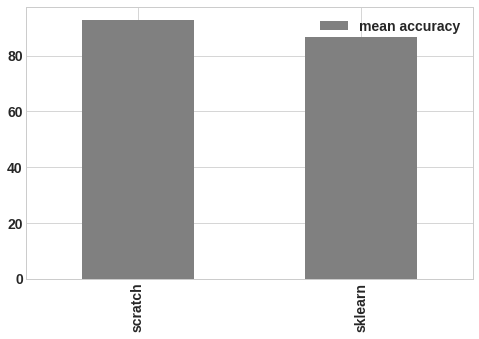

In [701]:
acc = [mean_accuracy,(mean_acc_scikit*100)]
col={'mean accuracy':acc}
models=['scratch','sklearn']
df1=pd.DataFrame(data=col,index=models)
df1.plot(kind ='bar', color = 'grey')

# K-Means Clustering on Iris Dataset

In [702]:
#import libraries
import pandas as pd
import numpy as np
import random as rd
import matplotlib.pyplot as plt

Load a CSV file

In [703]:
data = pd.read_csv('Iris.csv')
data.head()

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,Iris-setosa
1,2,4.9,3.0,1.4,0.2,Iris-setosa
2,3,4.7,3.2,1.3,0.2,Iris-setosa
3,4,4.6,3.1,1.5,0.2,Iris-setosa
4,5,5.0,3.6,1.4,0.2,Iris-setosa


Exploratory Data Analysis

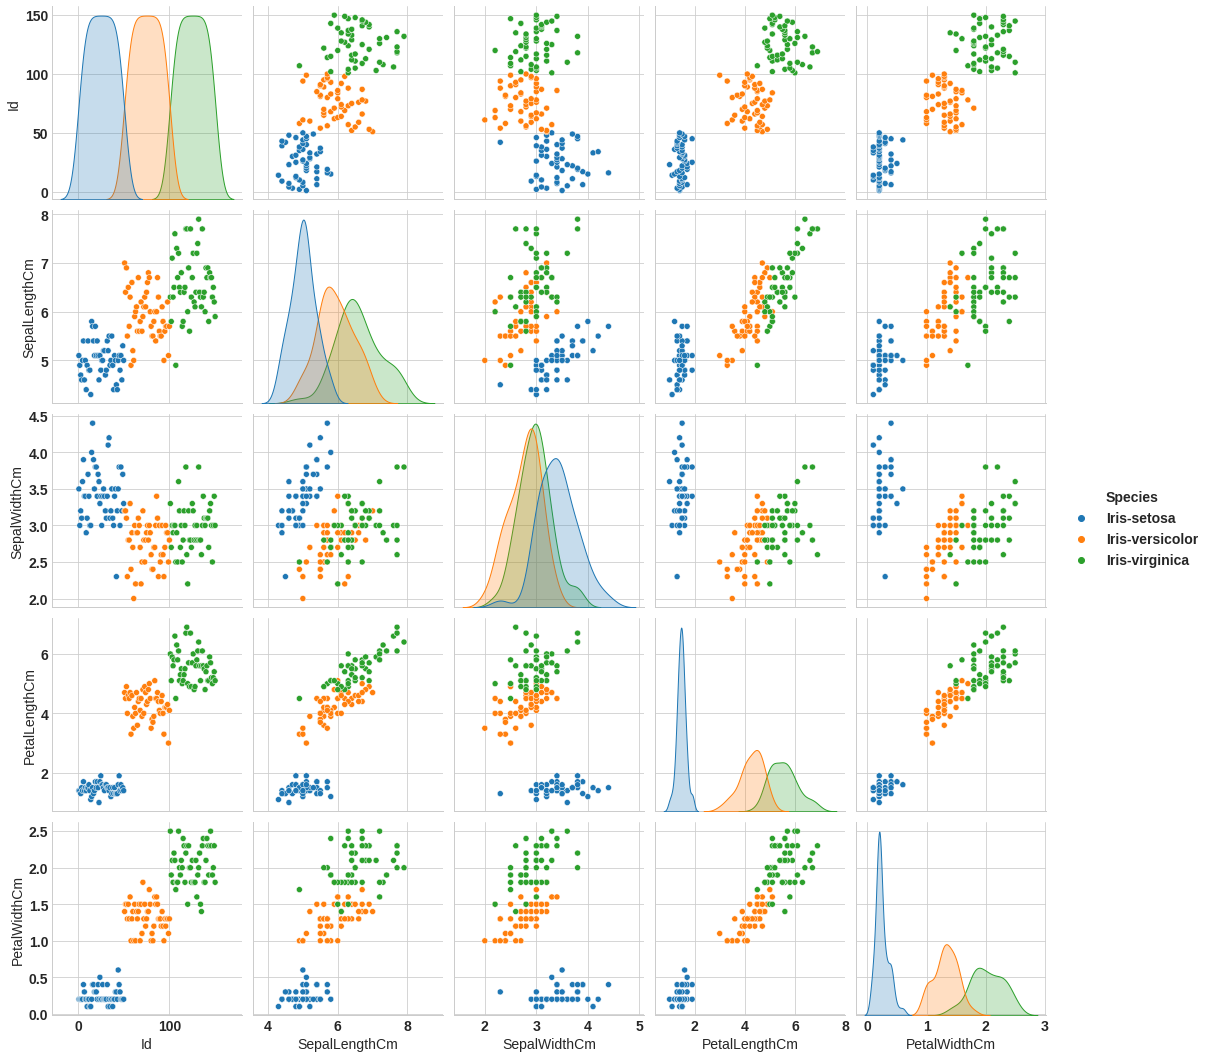

In [704]:
sns.pairplot(data, hue="Species", height=3)
plt.show()

In [705]:
data.isnull().sum()

Id               0
SepalLengthCm    0
SepalWidthCm     0
PetalLengthCm    0
PetalWidthCm     0
Species          0
dtype: int64

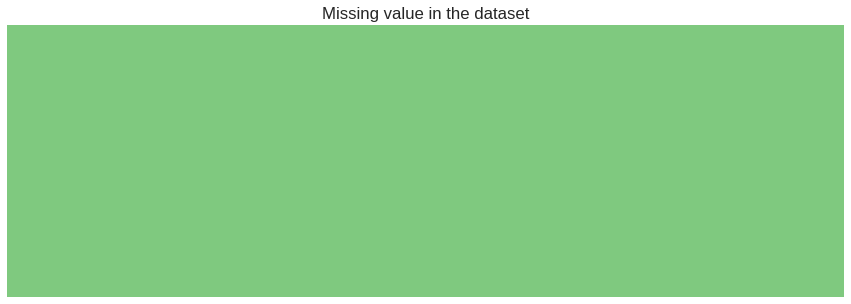

In [706]:
plt.figure(figsize=(15,5))
sns.heatmap(data.isnull(),cbar=False,cmap='Accent',yticklabels=False, xticklabels=False)
plt.title('Missing value in the dataset');

Visualise data points

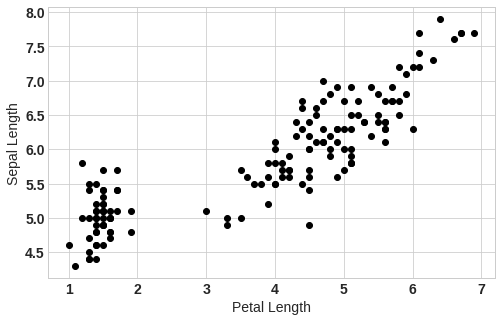

In [707]:
X = data[["SepalLengthCm","PetalLengthCm"]]
plt.scatter(X["PetalLengthCm"],X["SepalLengthCm"],c='black')
plt.xlabel('Petal Length')
plt.ylabel('Sepal Length')
plt.show()

Choose the number of clusters (k)

In [708]:
#number of clusters
K=3

Select random centroid for each cluster

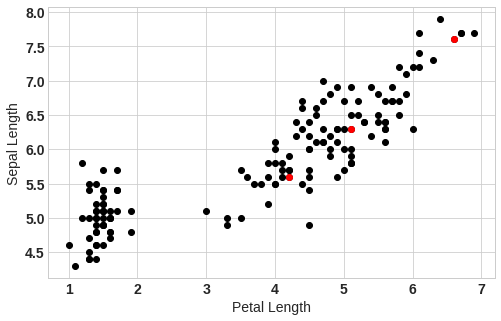

In [709]:
# Select random observation as centroids
Centroids = (X.sample(n=K))
plt.scatter(X["PetalLengthCm"],X["SepalLengthCm"],c='black')
plt.scatter(Centroids["PetalLengthCm"],Centroids["SepalLengthCm"],c='red')
plt.xlabel('Petal Length')
plt.ylabel('Sepal Length')
plt.show()

Assign all the points to the closest cluster centroid and recompute centroids of newly formed clusters

In [710]:
#Assign all the points to the closest cluster centroid and recompute centroids of newly formed clusters
#Repeat these steps

diff = 1
j=0

while(diff!=0):
    XD=X
    i=1
    for index1,row_c in Centroids.iterrows():
        ED=[]
        for index2,row_d in XD.iterrows():
            d1=(row_c["PetalLengthCm"]-row_d["PetalLengthCm"])**2
            d2=(row_c["SepalLengthCm"]-row_d["SepalLengthCm"])**2
            d=np.sqrt(d1+d2)
            ED.append(d)
        X[i]=ED
        i=i+1

    C=[]
    for index,row in X.iterrows():
        min_dist=row[1]
        pos=1
        for i in range(K):
            if row[i+1] < min_dist:
                min_dist = row[i+1]
                pos=i+1
        C.append(pos)
    X["Cluster"]=C
    Centroids_new = X.groupby(["Cluster"]).mean()[["SepalLengthCm","PetalLengthCm"]]
    if j == 0:
        diff=1
        j=j+1
    else:
        diff = (Centroids_new['SepalLengthCm'] - Centroids['SepalLengthCm']).sum() + (Centroids_new['PetalLengthCm'] - Centroids['PetalLengthCm']).sum()
        print("The difference between the centroids in the previous iteration and the current iteration: " +str(diff.sum()))
    Centroids = X.groupby(["Cluster"]).mean()[["SepalLengthCm","PetalLengthCm"]]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


The difference between the centroids in the previous iteration and the current iteration: -1.4305919672858498
The difference between the centroids in the previous iteration and the current iteration: -0.7755806654111717
The difference between the centroids in the previous iteration and the current iteration: -0.33578072940337145
The difference between the centroids in the previous iteration and the current iteration: -0.4325688839462425
The difference between the centroids in the previous iteration and the current iteration: -0.22457788574486903
The difference between the centroids in the previous iteration and the current iteration: -0.24990211138218665
The difference between the centroids in the previous iteration and the current iteration: -0.1398962148962175
The difference between the centroids in the previous iteration and the current iteration: -0.04612342459800001
The difference between the centroids in the previous iteration and the current iteration: -0.04712612792404958
The d

Visualize the clusters

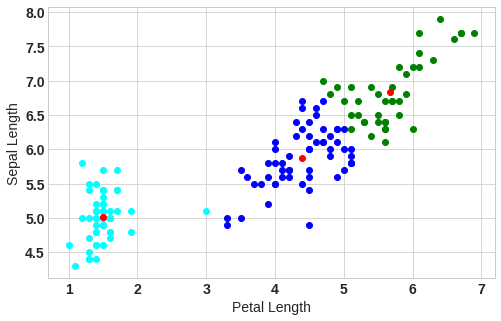

In [711]:
color=['blue','cyan','green']
for k in range(K):
    data=X[X["Cluster"]==k+1]
    plt.scatter(data["PetalLengthCm"],data["SepalLengthCm"],c=color[k])
plt.scatter(Centroids["PetalLengthCm"],Centroids["SepalLengthCm"],c='red')
plt.xlabel('Petal Length')
plt.ylabel('Sepal Length')
plt.show()